# Behavioral Cloning

In [1]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn.utils
import sklearn.model_selection
import cv2
%matplotlib inline
print('Tensorflow version {0}'.format(tf.__version__))
print('Keras version {0}'.format(keras.__version__))

Using TensorFlow backend.


Tensorflow version 1.3.0
Keras version 2.0.8


In [2]:
def change_brightness(img, lower_bound=0, upper_bound=255):
    '''
    Uniformly changes the brightness of an image randomly without overflowing.
    Change in brightness limited by original brightness of image
    '''
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img[:,:,2] = img[:,:,2]/2 + np.random.randint(lower_bound, upper_bound)/2
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [3]:
# def bin_angles(y, n_bins = 20):
#     '''Computes a bin number for each steering angle in order to balance classes'''
#     return np.floor((y - np.min(y))*n_bins/(np.max(y) - np.min(y)))

def bin_weights(y, n_bins=10):
    '''Balances numbered classes and returns array of weights to apply to each class'''
    y_bins = np.floor((y - np.min(y))*n_bins/(np.max(y) - np.min(y)))
    class_weight = sklearn.utils.class_weight.compute_class_weight('balanced', 
                                                                   np.unique(y_bins), 
                                                                   y_bins)
    class_dict = dict(zip(np.unique(y_bins), class_weight))
    return np.vectorize(class_dict.get)(y_bins)

## File I/O
Want to read in a directory of jpg files and write out hdf5

### Unbalanced Classes
We would like to have an equal distribution of steering angles to reduce the bias for zero driving angle. We will apply sample weights to balance the effect of each class.

(array([   412.,     84.,    105.,    122.,    122.,     93.,    148.,
           155.,    196.,    217.,    137.,    243.,    249.,    344.,
           173.,    383.,    369.,    429.,    526.,    576.,    248.,
           528.,    727.,   1088.,   1375.,  13497.,   1702.,   1169.,
           762.,    475.,    453.,    476.,    357.,    341.,    294.,
           173.,    279.,    242.,    238.,    134.,    201.,    185.,
           168.,    160.,     78.,    137.,    122.,    107.,     84.,
           327.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <a list of 50 Patch objects>)

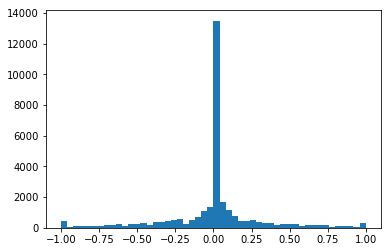

In [5]:
plt.hist(homogenous_samples[:,0], bins=50)

(array([ 412.,   84.,  105.,  122.,  122.,   93.,  148.,  155.,  196.,
         217.,  137.,  243.,  249.,  344.,  173.,  383.,  369.,  429.,
         506.,  576.,  248.,  495.,  522.,  476.,  519.,  482.,  464.,
         510.,  511.,  475.,  453.,  476.,  357.,  341.,  294.,  173.,
         279.,  242.,  238.,  134.,  201.,  185.,  168.,  160.,   78.,
         137.,  122.,  107.,   84.,  327.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <a list of 50 Patch objects>)

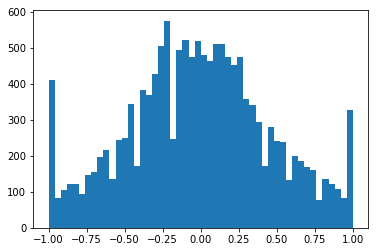

In [6]:
plt.hist(balanced_array[:,0], bins=50)

In [117]:
print(homogenous_samples.shape)
print(balanced_array.shape)

(31210, 5)
(14324, 5)


In [3]:
# Separate CSV into numpy array of strings and numpy array of floats
file_paths = np.genfromtxt('./driving_data/driving_log.csv', dtype=np.str, usecols=(0,1,2), delimiter=',')
homogenous_samples = np.genfromtxt('./driving_data/driving_log.csv', delimiter=',', usecols=(3,4,5,6))
# Compute sample weights
steering_angles = homogenous_samples[:,0]
# homogenous_samples = np.hstack((homogenous_samples, 
#                         np.expand_dims(bin_weights(steering_angles), axis=1)))

In [4]:
y = steering_angles
n_bins = 50
y_bins = np.floor((y - np.min(y))*n_bins/(np.max(y) - np.min(y)))
# homogenous_samples = np.hstack((homogenous_samples,
#                                 np.expand_dims(y_bins, axis=1)))

max_samples = 500
pct_keep = []
for bin_num in range(n_bins+1):
    bin_n = y_bins == bin_num
    bin_count = bin_n.sum()
    pct_keep.append(min(max_samples/bin_count, 1)) 
random_keep = np.random.rand(homogenous_samples.shape[0],)
class_dict = dict(zip(np.unique(y_bins), pct_keep))
keep_array = np.vectorize(class_dict.get)(y_bins)
delete_sample = random_keep > keep_array
indexes = np.arange(homogenous_samples.shape[0])
print(indexes[delete_sample])
balanced_array = np.delete(homogenous_samples, indexes[delete_sample], axis=0)
balanced_files = np.delete(file_paths, indexes[delete_sample], axis=0)

[    0     1     2 ..., 31202 31208 31209]


Save files to directory so that we can read them with `flow_from_directory`. Shoving them into an array causes memory errors.

### L-R Camera compensation

A correction factor of 0.1 is added to the left camera and subtracted from the right camera to compensate for the lateral position of the camera relative to the center. The value of the correction factor should be evaluated.

In [7]:
def generator(file_paths, samples, batch_size, lr_shift):
    num_samples = len(samples)
    if len(samples) != len(file_paths):
        print('TODO: Error Message, incompatible arrays {0} {1}'.format(len(samples), len(file_paths)))
    while True:
        file_paths, samples = sklearn.utils.shuffle(file_paths, samples)
        for offset in range(0, num_samples, batch_size):
            batch_files = file_paths[offset:offset + batch_size]
            batch_samples = samples[offset:offset + batch_size]
            
            images = []
            measurements = []
#             weights = []
            for batch_file in batch_files:
                #Read images from file
                center_file  = batch_file[0]
                left_file    = batch_file[1]
                right_file   = batch_file[2]
                center_image = mpimg.imread(center_file)
                left_image   = mpimg.imread(left_file)
                right_image  = mpimg.imread(right_file)
                #Flip images
                flip_center  = np.fliplr(center_image)
                flip_left    = np.fliplr(left_image)
                flip_right   = np.fliplr(right_image)
                #Change brightness of images
                center_image = change_brightness(center_image)
                left_image   = change_brightness(left_image)
                right_image  = change_brightness(right_image)
                flip_center  = change_brightness(flip_center)
                flip_left    = change_brightness(flip_left)
                flip_right   = change_brightness(flip_right)
                images.append(center_image)
                images.append(left_image)
                images.append(right_image)
                images.append(flip_center)
                images.append(flip_left)
                images.append(flip_right)
            
            for batch_sample in batch_samples:
                steer_angle  = batch_sample[0]
#                 sample_weight = batch_sample[4]
                
                #Steering angle offsets
                measurements.append(steer_angle)
                measurements.append(steer_angle+lr_shift)
                measurements.append(steer_angle-lr_shift)
                measurements.append(-steer_angle)
                measurements.append(-steer_angle-lr_shift)
                measurements.append(-steer_angle+lr_shift)
#                 weights += [sample_weight]*6
                
            X_train = np.array(images)
            y_train = np.array(measurements)
#             y_weights = np.array(weights)
            yield sklearn.utils.shuffle(X_train, y_train)#, y_weights)

In [8]:
BATCH_SIZE = 32
SHIFT = 0.1
train_files, val_files, train_samples, val_samples = \
    sklearn.model_selection.train_test_split(balanced_files, balanced_array, test_size=0.2)
train_generator = generator(train_files, train_samples, batch_size=BATCH_SIZE, lr_shift=SHIFT)
validation_generator = generator(val_files, val_samples, batch_size=BATCH_SIZE, lr_shift=SHIFT)

In [136]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D
from keras.layers import MaxPooling2D, Cropping2D, Dropout

model = Sequential()
model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/255.0 - 0.5))
model.add(Conv2D(24, (5,5), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(36, (5,5), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(48, (5,5), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(lr=0.0001))
history_object = model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_samples)/BATCH_SIZE,
                                     validation_data=validation_generator, 
                                     validation_steps=len(val_samples)/BATCH_SIZE,
                                     epochs=5, 
                                     verbose=2)
model.save('model{0}.h5'.format(np.datetime_as_string(np.datetime64('now'))))

Epoch 1/5
166s - loss: 0.0933 - val_loss: 0.0890
Epoch 2/5
146s - loss: 0.0719 - val_loss: 0.0642
Epoch 3/5
146s - loss: 0.0630 - val_loss: 0.0596
Epoch 4/5
146s - loss: 0.0577 - val_loss: 0.0553
Epoch 5/5
147s - loss: 0.0551 - val_loss: 0.0538


In [9]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D
from keras.layers import MaxPooling2D, Cropping2D, Dropout

model = Sequential()
model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/255.0 - 0.5))
model.add(Conv2D(24, (5,5), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(36, (5,5), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(48, (5,5), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='elu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(lr=0.0001))
history_object = model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_samples)/BATCH_SIZE,
                                     validation_data=validation_generator, 
                                     validation_steps=len(val_samples)/BATCH_SIZE,
                                     epochs=10, 
                                     verbose=2)
model.save('model{0}.h5'.format(np.datetime_as_string(np.datetime64('now'))))

Epoch 1/10
168s - loss: 0.1081 - val_loss: 0.0801
Epoch 2/10
162s - loss: 0.0773 - val_loss: 0.0694
Epoch 3/10
160s - loss: 0.0683 - val_loss: 0.0662
Epoch 4/10
159s - loss: 0.0635 - val_loss: 0.0610
Epoch 5/10
159s - loss: 0.0602 - val_loss: 0.0595
Epoch 6/10
149s - loss: 0.0568 - val_loss: 0.0600
Epoch 7/10
149s - loss: 0.0552 - val_loss: 0.0566
Epoch 8/10
148s - loss: 0.0531 - val_loss: 0.0590
Epoch 9/10
146s - loss: 0.0507 - val_loss: 0.0534
Epoch 10/10
147s - loss: 0.0491 - val_loss: 0.0550


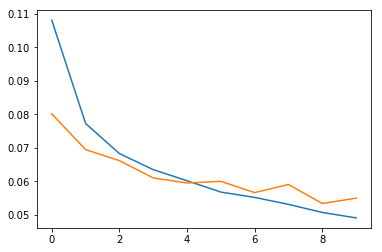

In [15]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 320, 24)       1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 160, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 160, 36)       21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 80, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 80, 48)        43248     
__________

In [17]:
from keras.utils import plot_model
plot_model(model, to_file='model{0}.png'.format(np.datetime_as_string(np.datetime64('now'))))

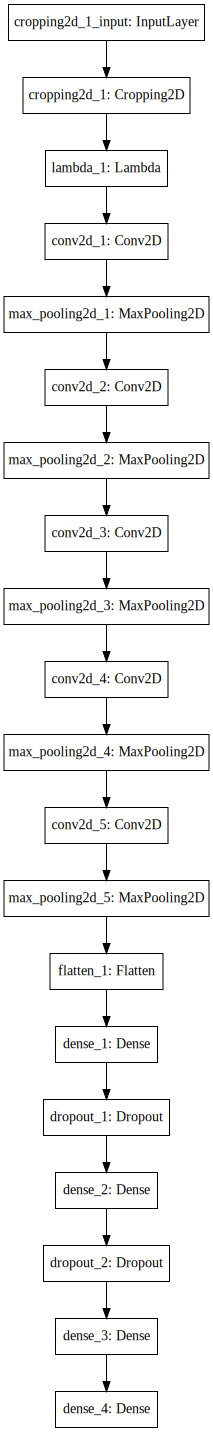

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

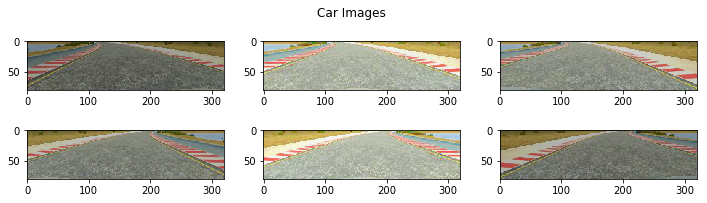

In [24]:
# center = mpimg.imread(log['CenterImg'][0])
# left = mpimg.imread(log['LeftImg'][0])
# right = mpimg.imread(log['RightImg'][0])
center_file  = balanced_files[0,0]
left_file    = balanced_files[0,1]
right_file   = balanced_files[0,2]
center_image = mpimg.imread(center_file)
left_image   = mpimg.imread(left_file)
right_image  = mpimg.imread(right_file)

center_image = center_image[60:140]
left_image   = left_image[60:140]
right_image  = right_image[60:140]

#Flip images
flip_center  = np.fliplr(center_image)
flip_left    = np.fliplr(left_image)
flip_right   = np.fliplr(right_image)
#Change brightness of images
center_image = change_brightness(center_image)
left_image   = change_brightness(left_image)
right_image  = change_brightness(right_image)
flip_center  = change_brightness(flip_center)
flip_left    = change_brightness(flip_left)
flip_right   = change_brightness(flip_right)

fig = plt.figure(figsize=(12,3))
plt.suptitle('Car Images')
axl = plt.subplot(2,3,1)
plt.imshow(left_image)
axc = plt.subplot(2,3,2)
plt.imshow(center_image)
axr = plt.subplot(2,3,3)
plt.imshow(right_image)
axl_f = plt.subplot(2,3,4)
plt.imshow(flip_left)
axc_f = plt.subplot(2,3,5)
plt.imshow(flip_center)
axr_f = plt.subplot(2,3,6)
plt.imshow(flip_right)

plt.show()